In [65]:
!pip install rectools lightgbm shap xgboost > None

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import warnings

warnings.simplefilter("ignore")

In [1]:
import gc
import json
import os
import random
from typing import Any, Dict, Tuple
from zipfile import ZipFile

import numpy as np
import pandas as pd
import requests
import shap
import xgboost as xgb
from lightgbm import LGBMClassifier, LGBMRanker
from rectools import Columns
from rectools.metrics import MAP, NDCG, MeanInvUserFreq, Precision, Recall, calc_metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tools import avg_user_metric
from tqdm.auto import tqdm

In [2]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [3]:
RANKER_DAYS_COUNT = 30
N_TOP_CANDIDATES = 100
K_RECOS = 10
OFFLINE_RECOS_PATH = "ranking_recos.json"

## Подготовка датасета

In [4]:
url = "https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip"

In [5]:
req = requests.get(url, stream=True)

with open("kion.zip", "wb") as fd:
    total_size_in_bytes = int(req.headers.get("Content-Length", 0))
    progress_bar = tqdm(desc="kion dataset download", total=total_size_in_bytes, unit="iB", unit_scale=True)
    for chunk in req.iter_content(chunk_size=2**20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [6]:
files = ZipFile("kion.zip", "r")
files.extractall()
files.close()

In [7]:
interactions_df = pd.read_csv("data_original/interactions.csv")

In [8]:
users = pd.read_csv("data_original/users.csv")
items = pd.read_csv("data_original/items.csv")

In [9]:
interactions_df.rename(
    columns={
        "last_watch_dt": Columns.Datetime,
        "watched_pct": Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions_df[Columns.Datetime] = pd.to_datetime(interactions_df[Columns.Datetime], format="%Y-%m-%d")

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
    Columns.Datetime: interactions_df[Columns.Datetime].median(),
    Columns.Weight: 0.0,
    "total_dur": 0,
}
interactions_df.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions_df.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


Кодируем категориальные колонки для юзеров и айтемов

In [10]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype("category").cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype("category")
    return df, cat_col_encoding


users_cat_cols = ["age", "income", "sex", "kids_flg"]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

users_cat_col_encoding["income"], users["income"].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [11]:
items_cat_cols = [
    "content_type",
    "for_kids",
    "studios",
]
items_text_cols = [
    "title",
    "title_orig",
    "genres",
    "countries",
    "directors",
    "actors",
    "description",
    "keywords",
]
items_num_cols = [
    "release_year",
    "age_rating",
]
default_values_items = {
    "release_year": items["release_year"].median(),
    "age_rating": items["age_rating"].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding["studios"]

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

Разбиваем датасет для обучения ранкера по следующей схеме валидации

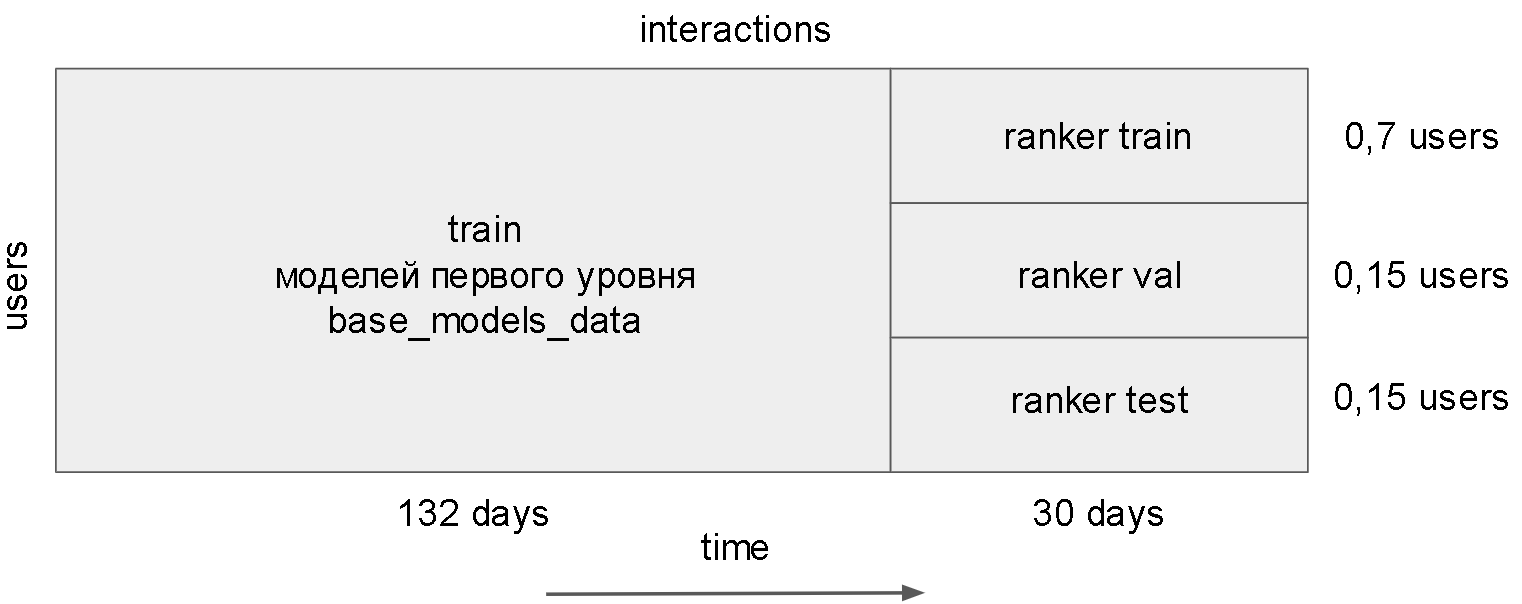

In [12]:
max_date = interactions_df[Columns.Datetime].max()
ranker_data = interactions_df[(interactions_df[Columns.Datetime] >= max_date - pd.Timedelta(days=RANKER_DAYS_COUNT))]

In [13]:
base_models_data = interactions_df[
    (interactions_df[Columns.Datetime] < max_date - pd.Timedelta(days=RANKER_DAYS_COUNT))
]

In [14]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(
    ranker_data["user_id"].unique(), random_state=RANDOM_STATE, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users,
    random_state=42,
    test_size=val_size / (train_size + val_size),  # 15% от общего размера
)

## Cбор кандидатов с первого уровня

Собираем кандидатов. У нас есть кандидаты от als, lightfm и популярные. Но als вместе со всеми использовать не будем, памяти столько нет

In [15]:
als_candidates = pd.read_csv("ranking/als_candidates.csv")

In [16]:
als_candidates.head()

,user_id,item_id,als_score,als_rank
0,176549,13865,0.413258,1
1,176549,10440,0.397711,2
2,176549,15297,0.235696,3
3,176549,7571,0.232902,4
4,176549,4151,0.229646,5


In [17]:
pop_candidates = pd.read_csv("ranking/pop_candidates.csv")

In [18]:
pop_candidates.drop(columns=["user_id"], inplace=True)

In [19]:
pop_candidates.head()

,item_id,pop_score,pop_rank
0,10440,141889.0,1
1,15297,137128.0,2
2,13865,93403.0,3
3,4151,69641.0,4
4,2657,55146.0,5


Собираем всех кандидатов

In [21]:
candidates = als_candidates.merge(pop_candidates, how="left", on=[Columns.Item])

In [22]:
candidates.head(5)

,user_id,item_id,als_score,als_rank,pop_score,pop_rank
0,176549,13865,0.413258,1,93403.0,3.0
1,176549,10440,0.397711,2,141889.0,1.0
2,176549,15297,0.235696,3,137128.0,2.0
3,176549,7571,0.232902,4,20407.0,15.0
4,176549,4151,0.229646,5,69641.0,4.0


In [23]:
del pop_candidates
del als_candidates
gc.collect()

471

## Датасет для ранкера

Генерим фичи для ранкера

In [24]:
# Получаем длину истории юзера
base_models_data["user_hist"] = base_models_data.groupby("user_id")["item_id"].transform("count")
# Получаем популярность контента
base_models_data["item_pop"] = base_models_data.groupby("item_id")["user_id"].transform("count")
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data["user_avg_pop"] = base_models_data.groupby("user_id")["item_pop"].transform("mean")
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data["item_avg_hist"] = base_models_data.groupby("item_id")["user_hist"].transform("mean")
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data["user_last_pop"] = base_models_data.groupby("user_id")["item_pop"].transform("first")
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [25]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(base_models_data[["item_id", "item_pop", "item_avg_hist"]].drop_duplicates()),
    how="left",
    on="item_id",
)

users = pd.merge(
    left=users,
    right=(base_models_data[["user_id", "user_hist", "user_avg_pop", "user_last_pop"]].drop_duplicates()),
    how="left",
    on="user_id",
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [26]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items["item_pop"] = base_models_data["item_pop"].median()
default_values_items["item_avg_hist"] = base_models_data["item_avg_hist"].median()

# Для новых фичей юзеров
default_values_users = {
    "user_hist": 0,
    "user_avg_pop": base_models_data["user_avg_pop"].median(),
    "user_last_pop": base_models_data["user_last_pop"].median(),
}

In [28]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты


def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="right",
        on=["user_id", "item_id"],
    )
    # Проставляем дефолтные значения интеракций
    pop_min_score: float = df["pop_score"].min() - 0.01
    pop_max_rank: int = df["pop_rank"].max() + 1
    als_min_score: float = df["als_score"].min() - 0.01
    als_max_rank: float = df["als_rank"].max() + 1

    default_values = {
        "als_score": als_min_score,
        "als_rank": als_max_rank,
        "pop_score": pop_min_score,
        "pop_rank": pop_max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank
11733036,3,14,2021-07-01,0.0,0.0,0.006987,37,5675.00,64.0
11733037,3,101,2021-07-01,0.0,0.0,0.006969,38,0.99,14942.0
11733005,3,142,2021-08-13,5892.0,100.0,0.054916,6,35862.00,8.0


In [29]:
# Добавляем фичи


def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df, users, how="left", on=["user_id"])
    df = pd.merge(df, items, how="left", on=["item_id"])

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df


# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank,age,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,14,2021-07-01,0.0,0.0,0.006987,37,5675.00,64.0,-1,...,0.0,11957.864865,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225
1,3,101,2021-07-01,0.0,0.0,0.006969,38,0.99,14942.0,-1,...,0.0,11957.864865,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673
2,3,142,2021-08-13,5892.0,100.0,0.054916,6,35862.00,8.0,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464


In [30]:
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'als_score',
       'als_rank', 'pop_score', 'pop_rank', 'age', 'income', 'sex', 'kids_flg',
       'user_hist', 'user_avg_pop', 'user_last_pop', 'content_type',
       'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop',
       'item_avg_hist'],
      dtype='object')

In [31]:
!rm -rf data && mkdir data

In [32]:
for name in ["train", "val", "test"]:
    path: str = f"data/ranker_{name}.csv"
    locals()[f"ranker_{name}"].to_csv(path, index=False)

In [33]:
del ranker_train, ranker_val, ranker_test
gc.collect()

815

## Эксперименты с ранкерами

In [17]:
# Загружаем данные
for name in ["train", "val", "test"]:
    path: str = f"data/ranker_{name}.csv"
    locals()[f"ranker_{name}"] = pd.read_csv(path)

Заведем функцию, чтобы считать метрики

In [35]:
# Считаем метрики


def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        "ndcg@10": NDCG(k=10),
        "map@10": MAP(k=10),
        "Precision@10": Precision(k=10),
        "recall@10": Recall(k=10),
        "novelty@10": MeanInvUserFreq(k=10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df.rename(columns={rank_col: Columns.Rank})[[Columns.User, Columns.Item, Columns.Rank]][
                candidates_df[Columns.User].isin(test_users)
            ]
        ),
        interactions=(
            ranker_data[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                ranker_data[Columns.User].isin(test_users)
            ]
        ),
        prev_interactions=(
            base_models_data[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                base_models_data[Columns.User].isin(test_users)
            ]
        ),
        catalog=items["item_id"].unique(),
    )

In [36]:
models_metrics: Dict[str, Dict[str, float]] = dict()

Сразу для моделей первого уровня метрики посчитаем, чтобы было, с чем сравнивать

In [37]:
models_metrics["als"] = calc_metrics_(candidates, "als_rank")

In [38]:
models_metrics["pop"] = calc_metrics_(candidates, "pop_rank")

In [39]:
pd.DataFrame(models_metrics)[["pop", "als"]]

,pop,als
Precision@10,0.018120,0.023253
recall@10,0.060863,0.076177
ndcg@10,0.022125,0.030793
map@10,0.028333,0.042003
novelty@10,3.135713,3.750258


**1. LightGBM Pointwise**

In [40]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df["target"] = df[Columns.Weight] > 50  # 'watched_pct'
    df["target"] = df["target"].astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank,age,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,14,2021-07-01,0.0,0.0,0.006987,37,5675.00,64.0,-1,...,11957.864865,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0
1,3,101,2021-07-01,0.0,0.0,0.006969,38,0.99,14942.0,-1,...,11957.864865,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0
2,3,142,2021-08-13,5892.0,100.0,0.054916,6,35862.00,8.0,-1,...,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1


In [41]:
def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    groups_df = df[["user_id", "item_id"]].groupby(by=["user_id"]).count().rename(columns={"item_id": "group_size"})
    df = pd.merge(df, groups_df, how="left", on=["user_id"])
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df["group_size"] >= 50]

    # Колонка больше не нужна
    df.drop(columns=["group_size"], inplace=True)
    return df


def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df["als_rank"] <= 100) & (df["pop_rank"] <= 100)]


ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

In [21]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    "als_score",
    "als_rank",
    "pop_score",
    "pop_rank",
    "age",
    "income",
    "sex",
    "kids_flg",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
    "studios",
    "item_pop",
    "item_avg_hist",
]
# Из них категориальные:
cat_cols = [
    "age",
    "income",
    "sex",
    "kids_flg",
    "content_type",
    "for_kids",
    "studios",
]

In [43]:
early_stopping_rounds = 32

params = {
    "objective": "binary",
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target"],
    "eval_set": [(ranker_val[cols], ranker_val["target"])],
    "eval_metric": "logloss",
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 47118, number of negative: 7292541
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.883763
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.176808
[LightGBM] [Debug] init for col-wise cost 0.112569 seconds, init for row-wise cost 0.262798 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.430595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1441
[LightGBM] [Info] Number of data points in the train set: 7339659, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Info] [bina

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=42, reg_lambda=1, verbose=4)

In [44]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_["valid_0"]["binary_logloss"]

0.032745307033178524

In [45]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:, :, 1]
shap_values.base_values = shap_values.base_values[:, 1]

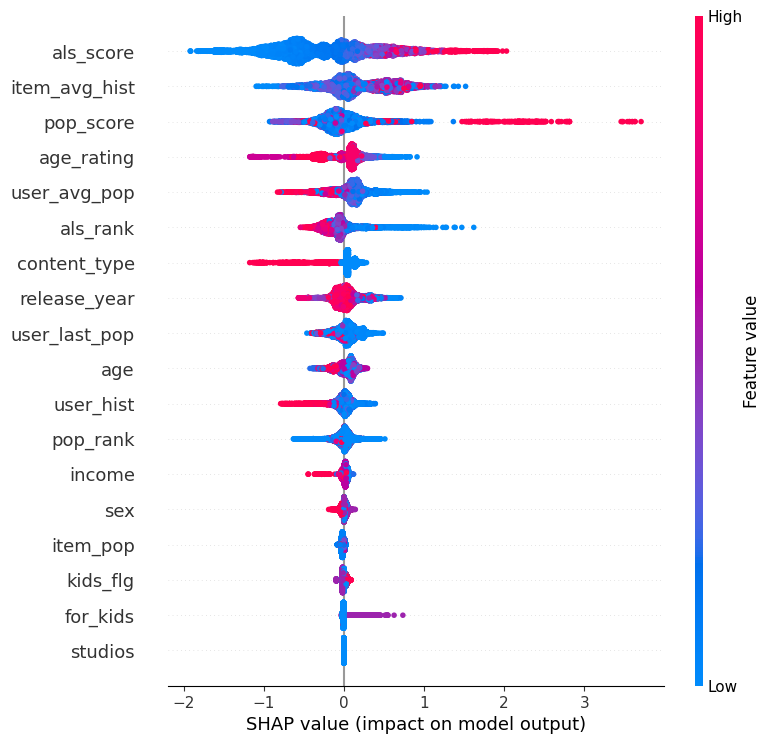

In [46]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

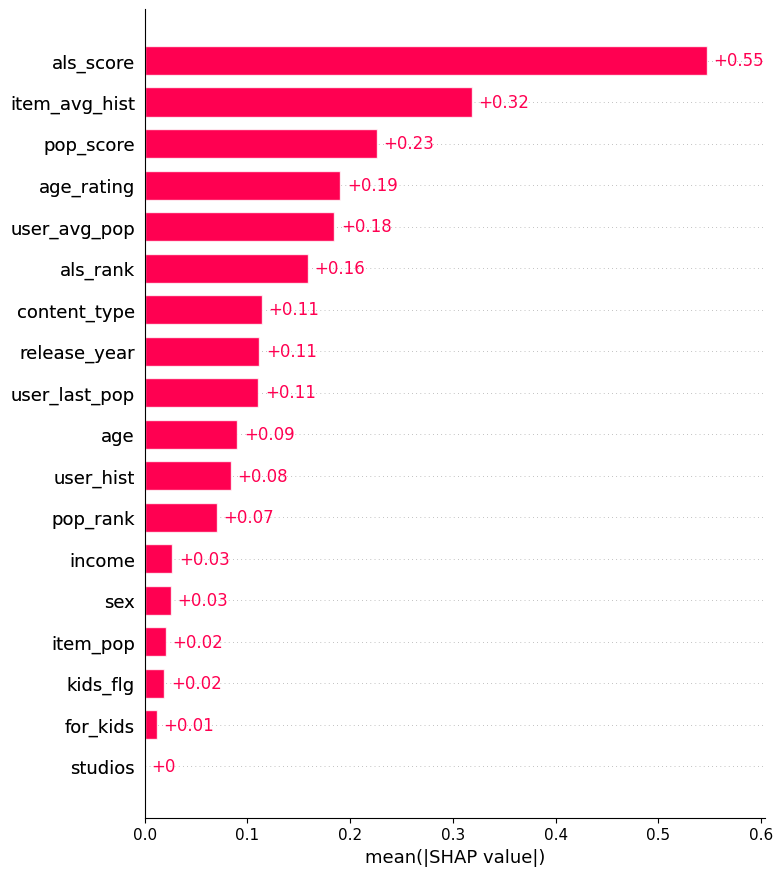

In [47]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [48]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test["target"])

y_pred

array([0.00250457, 0.00070384, 0.0012447 , ..., 0.00139274, 0.01473261,
       0.00389695])

In [28]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f"{name}_score"] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = ((df["als_rank"] < 51) & df["pop_rank"] < 51).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f"{name}_hybrid_score"] = df[f"{name}_score"] * mask
    df[f"{name}_hybrid_score"].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f"{name}_hybrid_rank"] = df[f"{name}_rank"] * mask
    max_rank: int = 51
    df[f"{name}_hybrid_rank"].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [50]:
ranker_test = add_score_and_rank(ranker_test, y_pred, "pointwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
24,53,3734,2021-07-30,11529.0,100.0,0.349451,3,50004.0,6.0,3,...,-1,16.0,-1,50004.0,12.134949,1,0.042817,1,0.042817,1
26,53,4151,2021-07-29,4302.0,13.0,0.588773,1,69641.0,4.0,3,...,-1,18.0,-1,69641.0,10.807886,0,0.035737,2,0.035737,2
54,53,7829,2021-07-01,0.0,0.0,0.054776,46,6028.0,58.0,3,...,-1,16.0,-1,6028.0,18.895322,0,0.025966,3,0.025966,3


In [51]:
(
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["pointwise_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["pointwise_hybrid_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
)

(0.7769019425452446, 0.7769019425452446)

In [52]:
# Получим значения метрик
models_metrics["pointwise"] = calc_metrics_(ranker_test, "pointwise_rank")
models_metrics["pointwise_hybrid"] = calc_metrics_(ranker_test, "pointwise_hybrid_rank")

In [55]:
pd.DataFrame(models_metrics)[["pop", "als", "pointwise_hybrid"]]

,pop,als,pointwise_hybrid
Precision@10,0.018120,0.023253,0.022707
recall@10,0.060863,0.076177,0.074671
ndcg@10,0.022125,0.030793,0.029074
map@10,0.028333,0.042003,0.038976
novelty@10,3.135713,3.750258,4.669952


**2. LightGBM Pairwise/Listwise**

In [53]:
# Для обучения ранжированию нужно правильно сформировать группы.
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества
# ранжируемых айтемов на каждого юзера (группу).


def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(df[["user_id", "item_id"]].groupby(by=["user_id"]).count()["item_id"])

In [54]:
# Добавим таргет посложнее


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df["target_ranker"] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df["target_ranker"] += (df[Columns.Weight] >= 75).astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank,age,...,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
0,3,14,2021-07-01,0.0,0.0,0.006987,37,5675.0,64.0,-1,...,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0,0
2,3,142,2021-08-13,5892.0,100.0,0.054916,6,35862.0,8.0,-1,...,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1,2
5,3,657,2021-07-01,0.0,0.0,0.005605,69,7157.0,48.0,-1,...,2858.0,0,2015.0,-1,18.0,-1,7157.0,23.835266,0,0


In [56]:
early_stopping_rounds = 32
params = {
    "objective": "lambdarank",  # lambdarank, оптимизирующий ndcg
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target_ranker"],
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target_ranker"])],
    "eval_group": [get_group(ranker_val)],
    "eval_metric": "ndcg",
    "eval_at": (3, 5, 10),
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.883763
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.176808
[LightGBM] [Debug] init for col-wise cost 0.111478 seconds, init for row-wise cost 0.386536 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.552860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1441
[LightGBM] [Info] Number of data points in the train set: 7339659, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=32, e

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [57]:
listwise_model.best_score_["valid_0"]

OrderedDict([('ndcg@3', 0.7647188860339206),
             ('ndcg@5', 0.7841647015752169),
             ('ndcg@10', 0.8028505259563986)])

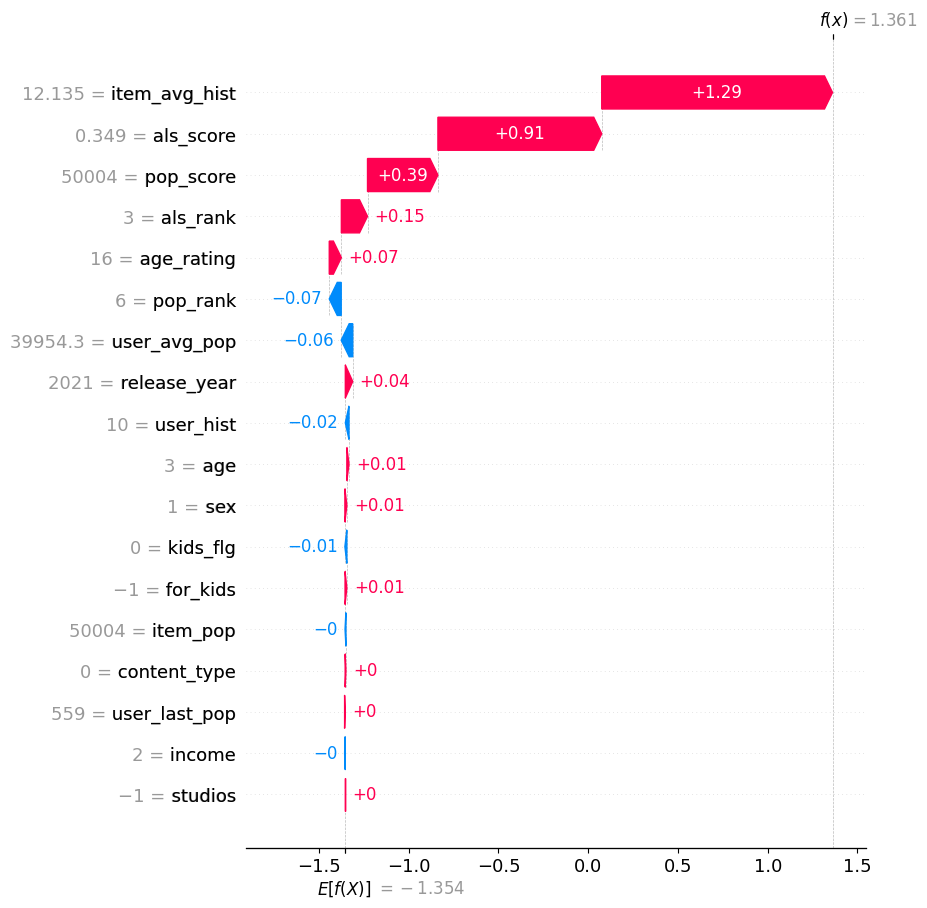

In [58]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

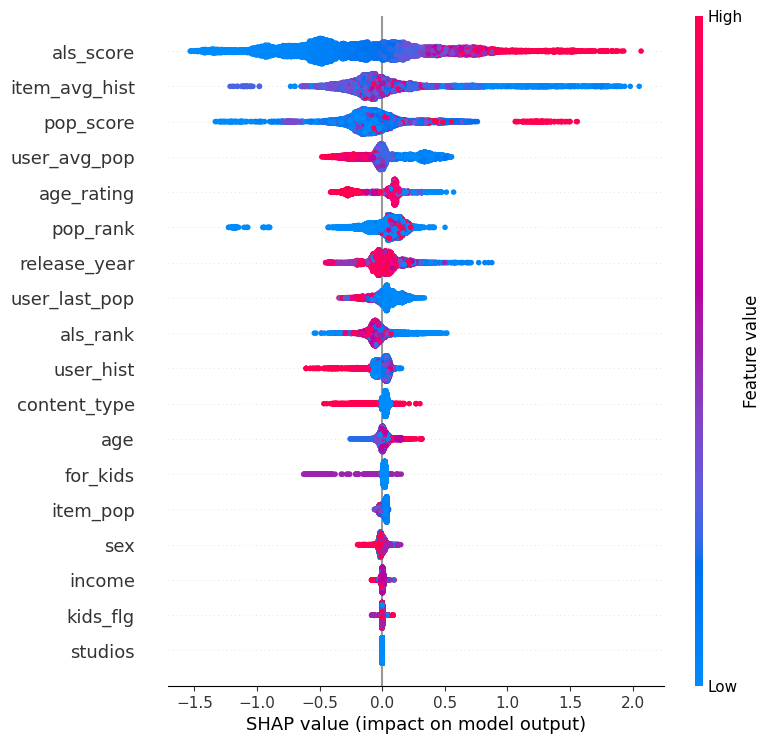

In [59]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

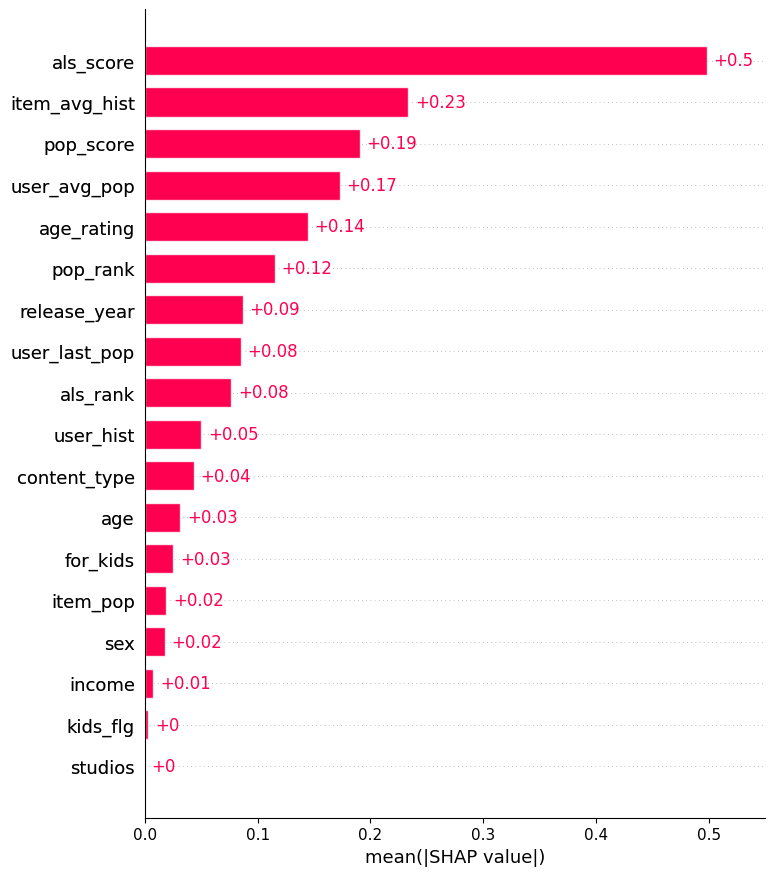

In [60]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [61]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank,age,...,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
77,53,12192,2021-07-01,0.0,0.0,0.074172,28,14317.0,23.0,3,...,0,0.009123,10,0.009123,10,0,1.878284,1,1.878284,1
26,53,4151,2021-07-29,4302.0,13.0,0.588773,1,69641.0,4.0,3,...,0,0.035737,2,0.035737,2,0,1.452275,2,1.452275,2
24,53,3734,2021-07-30,11529.0,100.0,0.349451,3,50004.0,6.0,3,...,1,0.042817,1,0.042817,1,2,1.361060,3,1.361060,3


In [62]:
models_metrics["listwise"] = calc_metrics_(ranker_test, "listwise_rank")
models_metrics["listwise_hybrid"] = calc_metrics_(ranker_test, "listwise_hybrid_rank")

In [63]:
(
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),  # target_ranker
        y_pred=np.array(ranker_test["listwise_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["listwise_hybrid_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
)

(0.7657123123644145, 0.7657123123644145)

**3. XGBoost PairWise**

In [18]:
## Формируем группы для xgboost


def get_group(df: pd.DataFrame) -> np.ndarray:
    return df.groupby("user_id").size().values

In [19]:
# Добавим таргет


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df["target_ranker"] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df["target_ranker"] += (df[Columns.Weight] >= 75).astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank,age,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker
0,3,14,2021-07-01,0.0,0.0,0.006987,37,5675.00,64.0,-1,...,11957.864865,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0
1,3,101,2021-07-01,0.0,0.0,0.006969,38,0.99,14942.0,-1,...,11957.864865,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0
2,3,142,2021-08-13,5892.0,100.0,0.054916,6,35862.00,8.0,-1,...,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,2


In [22]:
n_estimators = 10000
early_stopping_rounds = 32
learning_rate = 0.25
reg_alpha = 1e-1
reg_lambda = 1
max_depth = 4
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = RANDOM_STATE
enable_categorical = True

fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target_ranker"],
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target_ranker"])],
    "eval_group": [get_group(ranker_val)],
    "eval_metric": "ndcg@10",
}
XGB_model = xgb.XGBRanker(
    objective="rank:{}".format(objective),
    n_estimators=int(n_estimators),
    random_state=random_seed,
    learning_rate=learning_rate,
    early_stopping_rounds=early_stopping_rounds,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    max_depth=int(max_depth),
    max_leaves=int(max_leaves),
    grow_policy=grow_policy,
    verbosity=2,
    booster=booster,
    enable_categorical=enable_categorical,
)
XGB_model.fit(**fit_params)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=32, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.25, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=4, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=10000,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

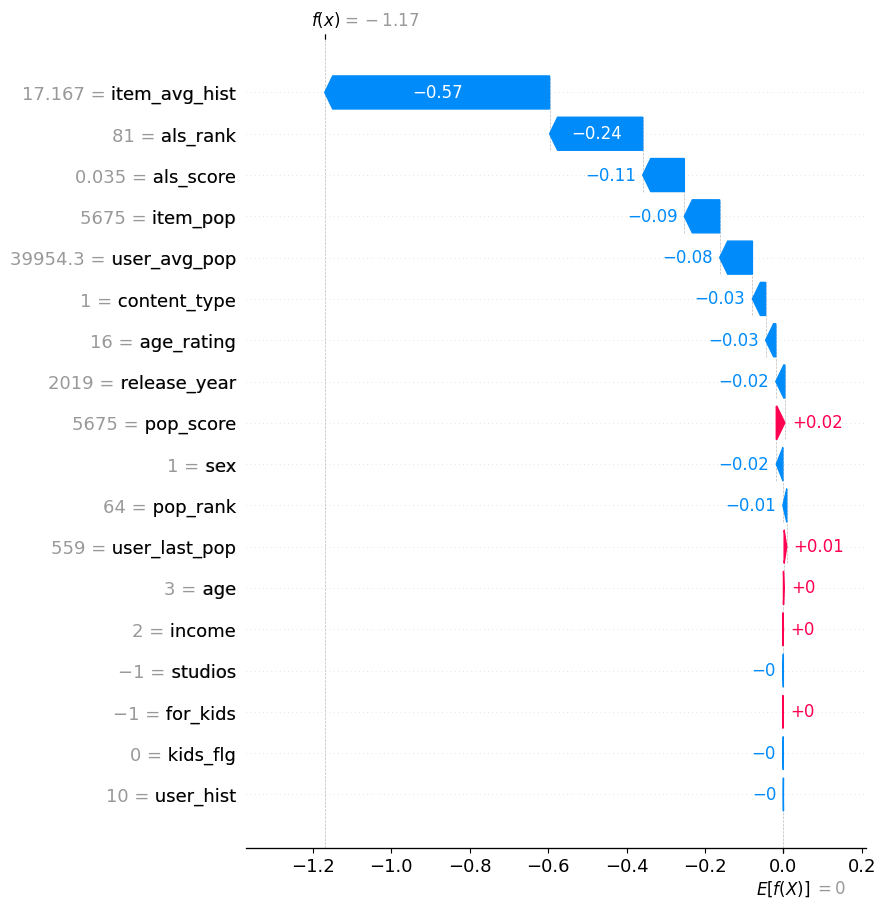

In [24]:
explainer = shap.Explainer(XGB_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

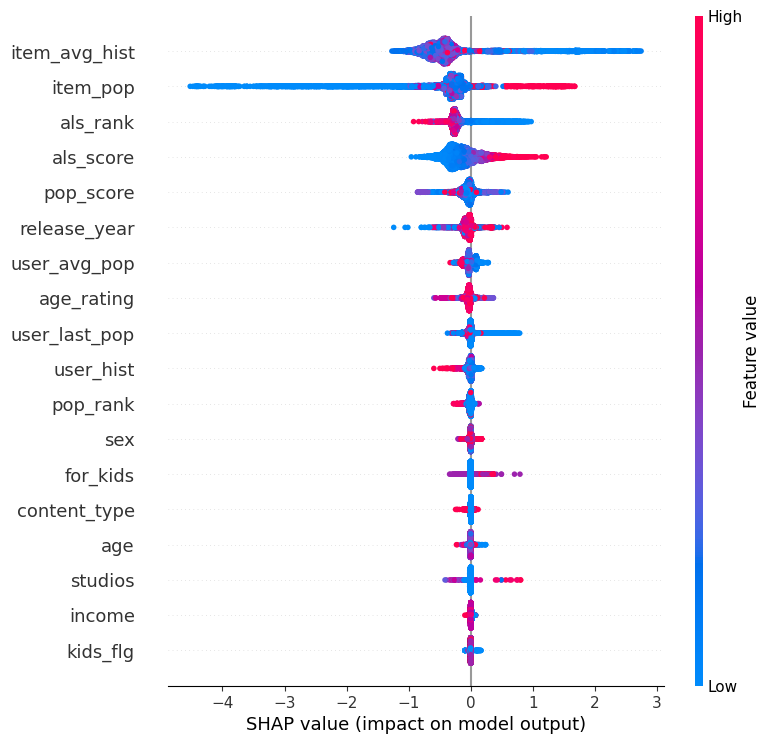

In [25]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

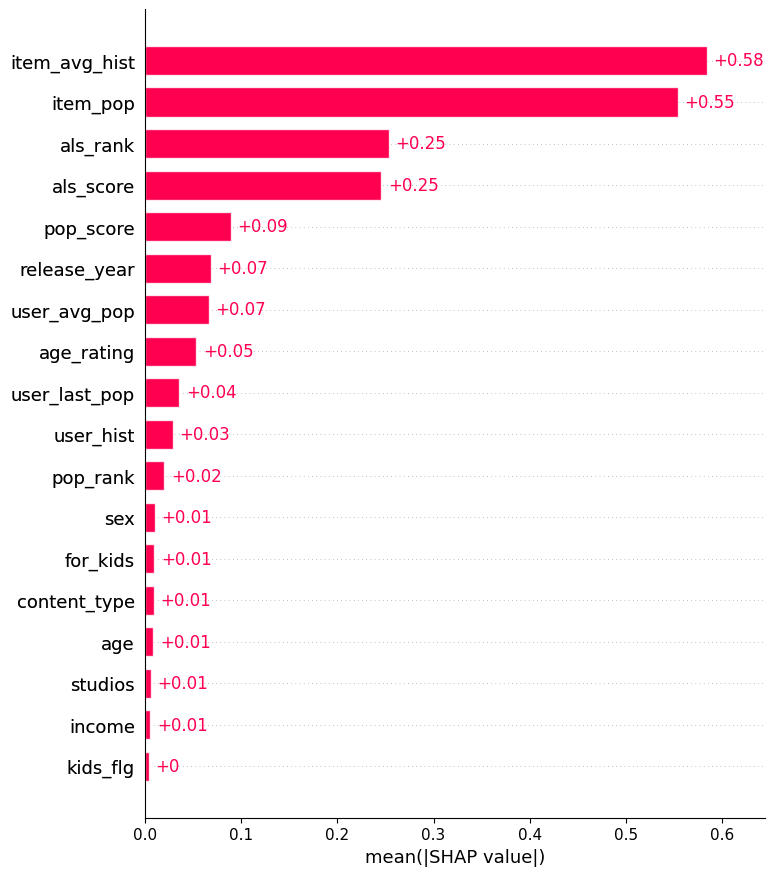

In [26]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [88]:
y_pred: np.ndarray = XGB_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, "hgb_pairwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank,age,...,pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank,hgb_pairwise_score,hgb_pairwise_rank,hgb_pairwise_hybrid_score,hgb_pairwise_hybrid_rank
77,53,12192,2021-07-01,0.0,0.0,0.074172,28,14317.0,23.0,3,...,10,0,1.878284,1,1.878284,1,3.304290,1,3.304290,1
24,53,3734,2021-07-30,11529.0,100.0,0.349451,3,50004.0,6.0,3,...,1,2,1.361060,3,1.361060,3,2.322514,2,2.322514,2
26,53,4151,2021-07-29,4302.0,13.0,0.588773,1,69641.0,4.0,3,...,2,0,1.452275,2,1.452275,2,2.064542,3,2.064542,3


In [89]:
models_metrics["hgb_pairwise"] = calc_metrics_(ranker_test, "hgb_pairwise_rank")
models_metrics["hgb_pairwise_hybrid"] = calc_metrics_(ranker_test, "hgb_pairwise_hybrid_rank")

In [90]:
(
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),  # target_ranker
        y_pred=np.array(ranker_test["hgb_pairwise_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["hgb_pairwise_hybrid_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
)

(0.7862945612307058, 0.7862945612307058)

## Итоговые метрики

In [91]:
pd.DataFrame(models_metrics)[["als", "pop", "pointwise_hybrid", "listwise_hybrid", "hgb_pairwise_hybrid"]]

,als,pop,pointwise_hybrid,listwise_hybrid,hgb_pairwise_hybrid
Precision@10,0.023253,0.018120,0.022707,0.024317,0.025316
recall@10,0.076177,0.060863,0.074671,0.080170,0.083968
ndcg@10,0.030793,0.022125,0.029074,0.031664,0.032474
map@10,0.042003,0.028333,0.038976,0.043527,0.044267
novelty@10,3.750258,3.135713,4.669952,4.432982,4.265718


**Итоговый вывод:** 

hgb_pairwise ранкер самый хороший по всем метрикам, кроме novelty, будем его использовать. Не стала замерять время, но по ощущениям, hgboost обучается сильно дольше, в отличие от lightgbm

## Соберем предикты для offline рекомендаций

In [30]:
# Загружаем данные заново
for name in ["train", "val", "test"]:
    path: str = f"data/ranker_{name}.csv"
    locals()[f"ranker_{name}"] = pd.read_csv(path)

In [31]:
ranker_full_data = pd.concat([ranker_train, ranker_val, ranker_test])

In [32]:
y_pred: np.ndarray = XGB_model.predict(ranker_full_data[cols])
ranker_full_data = add_score_and_rank(ranker_full_data, y_pred, "hgb_pairwise")
ranker_full_data.head()

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,pop_score,pop_rank,age,...,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,hgb_pairwise_score,hgb_pairwise_rank,hgb_pairwise_hybrid_score,hgb_pairwise_hybrid_rank
91,3,15297,2021-07-01,0.0,0.0,0.080530,4,137128.00,2.0,-1,...,2021.0,-1,18.0,-1,137128.0,7.364295,3.881613,1,3.881613,1
60,3,10440,2021-07-23,44827.0,90.0,0.162053,1,141889.00,1.0,-1,...,2021.0,-1,18.0,-1,141889.0,8.068716,3.842571,2,3.842571,2
54,3,9728,2021-07-23,10448.0,100.0,0.058190,5,0.99,14942.0,-1,...,2021.0,-1,18.0,-1,76978.0,11.165736,3.026067,3,3.026067,3
79,3,13865,2021-07-01,0.0,0.0,0.091499,3,93403.00,3.0,-1,...,2021.0,-1,12.0,-1,93403.0,10.408520,2.140997,4,2.140997,4
22,3,4151,2021-07-24,17606.0,88.0,0.111361,2,69641.00,4.0,-1,...,2021.0,-1,18.0,-1,69641.0,10.807886,1.956431,5,1.956431,5


In [33]:
ranker_full_data = ranker_full_data[["user_id", "item_id", "hgb_pairwise_hybrid_rank"]]
ranker_full_data = (
    ranker_full_data.sort_values(["user_id", "hgb_pairwise_hybrid_rank"]).groupby("user_id").head(K_RECOS)
)
ranker_full_data.drop("hgb_pairwise_hybrid_rank", axis=1, inplace=True)
ranker_full_data.head()

,user_id,item_id
91,3,15297
60,3,10440
54,3,9728
79,3,13865
22,3,4151


In [35]:
recos = ranker_full_data.groupby("user_id").agg(list).to_dict()["item_id"]

In [36]:
with open(OFFLINE_RECOS_PATH, "w") as recos_file:
    json.dump(recos, recos_file)